# Prompt

## Try It: Comparing Feature Selection Methods

In this module, you have seen two ways to select features.  The first approach is using sequential feature selection to sequentially add or delete features and only use those that improve the model.  The second approach is using a regularized model to identify features based on non-zero coefficients.  This activity focuses on comparing variations of both these methods.  

You will use both the `SequentialFeatureSelection` and `RFE` (recursive feature elimination) to build and compare regression models.  Consider the following feature selection methods -- leave all other arguments to default besides the `estimator` and `n_features_to_select` arguments:

- `Ridge` regressor to extract coefficients
- `SequentialFeatureSelection` using the `Lasso` to select 4 features.
- `RFE` using `Lasso` to select 4 features.

For each of these, fit the training data `X_train`, `y_train` below.  Compare the magnitude of the results of your `Ridge` model to those that result from feature selection methods.  

## Data Description

For this problem a dataset with information on red wine chemical compositions and their quality is given.  Your goal is to use the properties of the wine to predict the quality.  Below, the data is loaded and train/test splits constructed.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import warnings
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import mean_squared_error
from IPython.display import Image

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [3]:
df = pd.read_csv("./data/wine-quality-red.csv")

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# Model Prep

## Feature and Frame Naming

### Features

In [6]:
target_feature = "quality"
numeric_features = df.columns[df.dtypes != "object"].to_list()
numeric_features.remove(target_feature)

### Frames

In [7]:
X = df.drop(columns=target_feature)
y = df[target_feature]
# y.hist()

## Perform a Default Split

In [8]:
(X_train, X_dev, y_train, y_dev, train_inds, dev_inds) = train_test_split(
    X, y, range(len(df)), random_state=42
)

# Regression

## Ridge

Little bit confused by the prompt... do they really want just a trivial pipeline here?

In [9]:
ridge_pipe = Pipeline(
    [
        ("regression", Ridge()),
    ]
)

## Sequential Feature Selection with Lasso

In [10]:
sfs_pipe = Pipeline(
    [
        (
            "selector",
            SequentialFeatureSelector(estimator=Lasso(), n_features_to_select=4),
        ),
        ("regression", Ridge()),
    ]
)

## Recursive Feature Elimination with Lasso

In [11]:
rfe_pipe = Pipeline(
    [
        (
            "selector",
            RFE(estimator=Lasso(), n_features_to_select=4),
        ),
        ("regression", Ridge()),
    ]
)

# Comparing Coefficients

## Make a Data Frame with Coefficients per Feature Selector Type

In [16]:
estimators = [ridge_pipe, sfs_pipe, rfe_pipe]
estimator_names = ["All Features", "SFS Lasso", "RFE Lasso"]
coefs_df = pd.DataFrame()
train_mse = []
dev_mse = []

for k in range(len(estimators)):
    estimator = estimators[k].fit(X_train, y_train)
    if k == 0:
        columns = estimator.feature_names_in_
    else:
        columns = estimator.named_steps["selector"].get_feature_names_out()

    intercept = estimator.named_steps["regression"].intercept_
    coefs = np.abs(estimator.named_steps["regression"].coef_)
    model_params_names = ["intercept"] + columns.tolist()

    coefs_df[estimator_names[k]] = pd.Series(
        [intercept] + coefs.tolist(),
        model_params_names,
    )

    train_mse.append(
        mean_squared_error(y_true=y_train, y_pred=estimator.predict(X_train))
    )

    dev_mse.append(mean_squared_error(y_true=y_dev, y_pred=estimator.predict(X_dev)))

coefs_df

,All Features,SFS Lasso,RFE Lasso
intercept,3.818600,6.670341,3.264543
fixed acidity,0.012650,0.009970,NaN
volatile acidity,1.030705,1.500357,NaN
citric acid,0.155604,0.185801,NaN
residual sugar,0.000648,NaN,NaN
chlorides,1.178000,NaN,NaN
free sulfur dioxide,0.005134,NaN,NaN
total sulfur dioxide,0.003590,0.004550,0.002889
density,0.014613,NaN,NaN
pH,0.355665,NaN,0.520745


In [13]:
pd.DataFrame(
    [["Train"] + train_mse, ["Dev"] + dev_mse], columns=["MSE"] + estimator_names
)

,MSE,All Features,SFS Lasso,RFE Lasso
0,Train,0.428214,0.547860,0.467789
1,Dev,0.390992,0.503412,0.441475


## Bar Plot of Coefs

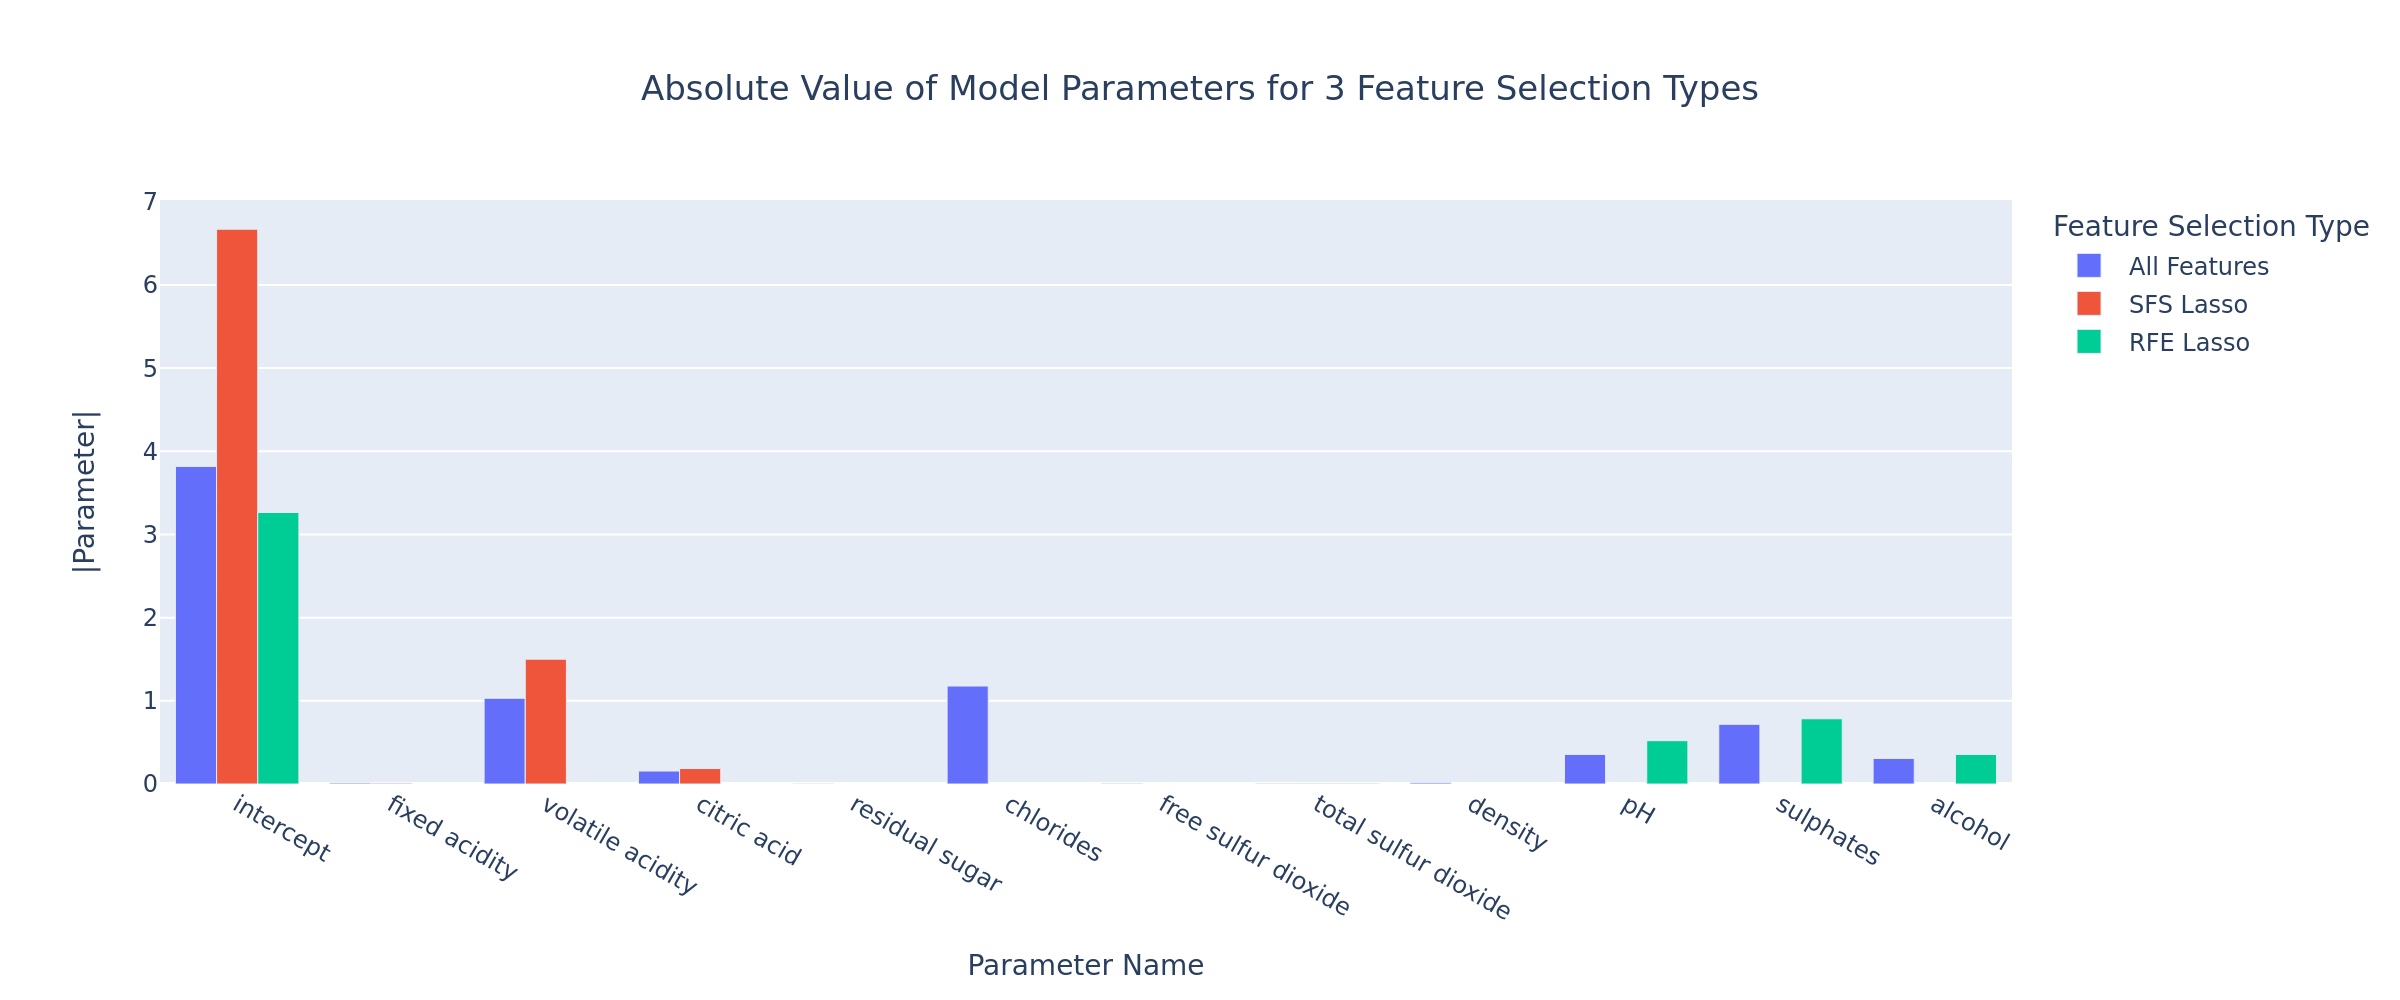

In [17]:
fig = px.bar(
    coefs_df,
    barmode="group",
    title="Absolute Value of Model Parameters for 3 Feature Selection Types",
    labels={
        "index": "Parameter Name",
        "value": "|Parameter|",
        "variable": "Feature Selection Type",
    },
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))